# Stable Diffusion

> Fill in a module description here

In [1]:
#| default_exp stable_diffusion

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| hide
import nbdev; nbdev.nbdev_export()

In [4]:
#| export
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from transformers import CLIPTokenizer, CLIPTextModel

from tqdm.auto import tqdm
from PIL import Image

/Users/education/miniforge3/envs/sb-from-scratch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the models

In [5]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")


# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.9.layer_norm1.weight', 'vision_model.encoder.layers.15.self_attn.v_proj.weight', 'vision_model.encoder.layers.2.layer_norm2.weight', 'text_projection.weight', 'vision_model.encoder.layers.8.layer_norm2.weight', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.layers.11.mlp.fc2.bias', 'vision_model.encoder.layers.15.mlp.fc1.bias', 'vision_model.encoder.layers.13.layer_norm2.weight', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.19.self_attn.q_proj.weight', 'vision_model.encoder.layers.22.mlp.fc2.weight', 'vision_model.encoder.layers.18.layer_norm1.bias', 'vision_model.encoder.layers.12.layer_norm2.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.bias', 'vision_model.encoder.layers.5.self_attn.q_proj.weight', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model

### A diffusion loop

In [7]:
prompt = ["Starship on Mars"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

In [8]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [10]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [11]:
text_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.0247,  0.9459,  0.7654,  ..., -1.1003, -0.2606,  0.8842],
         [ 0.4559,  0.1749,  1.0120,  ..., -1.0061, -0.5178,  0.3135],
         ...,
         [ 0.1388, -0.4998, -1.2958,  ..., -1.4081, -0.5799,  0.1381],
         [ 0.1355, -0.5146, -1.2836,  ..., -1.4116, -0.5853,  0.1313],
         [ 0.1215, -0.4565, -1.2296,  ..., -1.3972, -0.5584,  0.0839]]])

In [12]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [13]:
text_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.0247,  0.9459,  0.7654,  ..., -1.1003, -0.2606,  0.8842],
         [ 0.4559,  0.1749,  1.0120,  ..., -1.0061, -0.5178,  0.3135],
         ...,
         [ 0.1388, -0.4998, -1.2958,  ..., -1.4081, -0.5799,  0.1381],
         [ 0.1355, -0.5146, -1.2836,  ..., -1.4116, -0.5853,  0.1313],
         [ 0.1215, -0.4565, -1.2296,  ..., -1.3972, -0.5584,  0.0839]]])

In [14]:
# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

In [15]:
# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

In [16]:

# Loop
with torch.autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

/Users/education/miniforge3/envs/sb-from-scratch/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
30it [03:56,  7.90s/it]


In [17]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

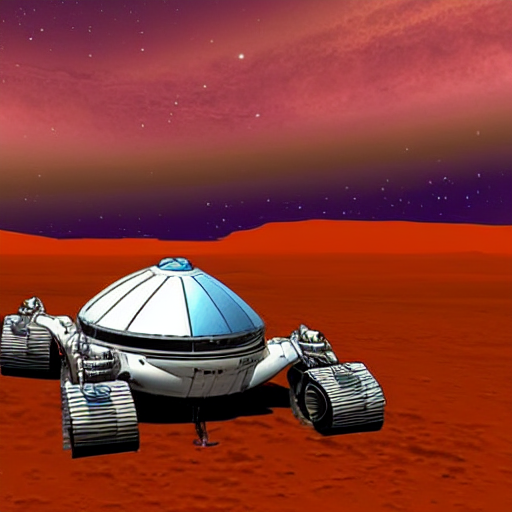

In [18]:
# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]
